# Benchmark Analysis

In [1]:
%cd ..

/Users/lorenzorota/Documents/Academics/University/University-of-Groningen/Masters/Courses/semester-4/Thesis/Code/activesecuritympc


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import numpy as np
import os

In [3]:
if not os.path.exists("figures"):
    os.makedirs("figures")

In [4]:
N=24
passive_readings = []
for i in range(3, N):
    file = f"benchmarks/sum_passive_{i}_parties.csv"
    passive_readings.append(pd.read_csv(file))
passive_readings = pd.concat(passive_readings)
passive_readings['total_communication_cost'] = passive_readings['total_bytes_sent'] + passive_readings['total_bytes_recv']
passive_readings = passive_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

groth16_readings = []
for i in range(3, N):
    file = f"benchmarks/sum_active_groth16_{i}_parties.csv"
    groth16_readings.append(pd.read_csv(file))
groth16_readings = pd.concat(groth16_readings)
# Group by 'parties' and 'ensemble' and set 'total_crs_generation_time' to the value of id==0 for each group
groth16_readings['total_crs_generation_time'] = groth16_readings.groupby(['parties', 'ensemble'])['total_crs_generation_time'].transform(lambda x: x.iloc[0])
groth16_readings['total_communication_cost'] = groth16_readings['total_bytes_sent'] + groth16_readings['total_bytes_recv']
groth16_readings['total_verification_time_per_party'] = groth16_readings['total_verification_time'] / groth16_readings['parties']
groth16_readings = groth16_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

bulletproofs_readings = []
for i in range(3, N):
    file = f"benchmarks/sum_active_bulletproofs_{i}_parties.csv"
    bulletproofs_readings.append(pd.read_csv(file))
bulletproofs_readings = pd.concat(bulletproofs_readings)
bulletproofs_readings['total_communication_cost'] = bulletproofs_readings['total_bytes_sent'] + bulletproofs_readings['total_bytes_recv']
bulletproofs_readings['total_verification_time_per_party'] = bulletproofs_readings['total_verification_time'] / bulletproofs_readings['parties']
bulletproofs_readings = bulletproofs_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

parties = range(3, N)

In [5]:
def get_all_measurements_alongside_median(data, pivot_column):
    # Group by 'parties' and 'id'
    grouped_data = data.groupby(['parties', 'id'])
    std_data = grouped_data.std()
    std_data = std_data.drop(columns='ensemble')

    # Calculate the median of the pivot_column for each group
    median_values = grouped_data[pivot_column].median()

    # Find the row with the closest value to the median pivot_column value
    median_data = pd.DataFrame([])
    for group, median_value in median_values.items():
        close_values = data[(data['parties'] == group[0]) & (data['id'] == group[1])]
        closest_values = close_values.loc[close_values[pivot_column].sub(median_value).abs().idxmin()]
        median_data = pd.concat([median_data, pd.DataFrame([closest_values])], ignore_index=False)

    median_data = median_data.drop(columns='ensemble')
    return median_data, std_data

In [6]:
def produce_plot(fig, ax, data, metric_dict, metric='total_runtime', std=True, median_column='total_runtime', id=0, semilog=False, style=None, loc=None):
    median_data, std_data = get_all_measurements_alongside_median(data, median_column)
    
    # Get data specifically for selected party
    data_party = median_data[median_data['id'] == id]
    std_data_party = std_data[std_data.index.get_level_values('id') == id]
    
    # Produce plot for a given metric
    parties = data_party['parties']
    specific_data = data_party[metric]
    std_dev = std_data_party[metric]
    
    if style:
        marker = style.get("marker", 'o')
        linestyle = style.get("linestyle", '-')
        color = style.get("color", '0')
    else:
        marker = 'o'
        linestyle = '-'
        color = '0'
    
    if std:
        ax.errorbar(parties, specific_data, yerr=std_dev, marker=marker, linestyle=linestyle, linewidth=1, capsize=3, markersize=6, color=color, label=style["label"])
    else:
        ax.plot(parties, specific_data, marker=marker, linestyle=linestyle, linewidth=1, markersize=6, color=color, label=style["label"])
        
    ax.minorticks_on()
    if semilog:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale
        # Add major grid lines for better readability
        ax.yaxis.grid(True, linestyle='-', alpha=0.3)
        # Add minor grid lines as dotted lines
        ax.yaxis.grid(which='minor', linestyle='--', alpha=0.15)
    ax.xaxis.set_major_locator(AutoLocator())
    ax.set_xlim(3-0.5, max(parties)+0.5)
    ax.set_xlabel('parties', fontsize=12)
    ax.set_ylabel(metric_dict[metric], fontsize=12)
    if loc is not None:
        ax.legend(loc=loc, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    return fig, ax, specific_data

In [7]:
def produce_bar(bar_positions, heights, width=0.8, style=None, bottom=None, edgecolor='black'):
    bars = plt.bar(bar_positions, heights, width=width, bottom=bottom, edgecolor=edgecolor, hatch=style['hatch'], color=style['color'], label=style['label'])
    return bars

In [8]:
def calculate_bottoms(bar_positions, heights_list):
    bottoms = []
    for pos in bar_positions:
        if not bottoms:
            bottoms.append(heights_list[pos])
        else:
            last_bottom = bottoms[-1]
            new_bottom = last_bottom.add(heights_list[pos], fill_value=0)
            bottoms.append(new_bottom)
    return bottoms

In [9]:
def create_legend(styles, filename, option='plot', ncol=2):
    # Create a figure for the legend only
    legend_fig = plt.figure(figsize=(4, 0.5))
    legend_ax = legend_fig.add_subplot(111)

    # Create custom legend handles and labels
    legend_handles = []
    legend_labels = []
    for style in styles:
        if option == 'bar':
            handle = Rectangle((1, 1), 1, 1, facecolor=style["color"], edgecolor='black', hatch=style.get("hatch", None))
        else:
            handle = Line2D([0], [0], marker=style["marker"], linestyle=style["linestyle"],
                             color=style["color"], linewidth=1, markersize=6)
        legend_handles.append(handle)
        legend_labels.append(style["label"])

    # Plot invisible data to create legend entries
    for handle, label in zip(legend_handles, legend_labels):
        if option == 'bar':
            legend_ax.add_patch(handle)
        else:
            legend_ax.plot([], [], label=label, color='none')

    # Add legend to the figure
    legend_ax.legend(handles=legend_handles, labels=legend_labels, fontsize=12, ncol=ncol, frameon=True, fancybox=False, loc='center')
    legend_ax.axis('off')
    legend_fig.savefig(filename, bbox_inches='tight')
    plt.show(legend_fig)
    plt.close(legend_fig)

In [10]:
names = {
    "total_zkp_constraints": "constraints",
    "total_zkp_compile_time": "time (sec)",
    "total_proof_size": "size (bytes)",
    "total_proving_time": "time (sec)",
    "total_crs_generation_time": "time (sec)",
    "total_crs_len": "size (bytes)",
    "total_verification_time": "time (sec)",
    "total_verification_time_per_party": "time (sec)",
    "zkif_export_size":  "size (bytes)",
    "zkp_data_size":  "size (bytes)",
    "zkp_params_and_proofs_size":  "size (bytes)",
    "cache_size": "size (bytes)",
    "setup_communication": "data (bytes)",
    "engagement_communication": "data (bytes)",
    "emulation_communication": "data (bytes)",
    "total_communication_cost": "data (bytes)",
    "setup_time": "time (sec)",
    "engagement_time": "time (sec)",
    "emulation_time": "time (sec)",
    "total_communication_time": "time (sec)",
    "total_runtime": "time (sec)",
}

## Analysis

We start with the basics, i.e. overall runtime and communication cost for passive, active (groth16) and active (bulletproofs), as well as storage/memory usage for active (groth16) and active (bulletproofs)

### Overall measurements

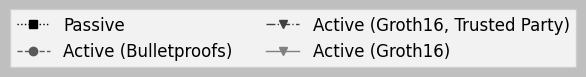

In [42]:
# colorful
# styles = [
#     {"label": "Passive", "marker": 's', "linestyle": 'dotted', "color": '#E69F00'},
#     {"label": "Active (Bulletproofs)", "marker": 'o', "linestyle": '--', "color": '#56B4E9'},
#     {"label": "Active (Groth16, Trusted Party)", "marker": 'v', "linestyle": '-.', "color": '#0072B2'},
#     {"label": "Active (Groth16)", "marker": 'v', "linestyle": '-', "color": '#009E73'}
# ]

# gray scale
styles = [
    {"label": "Passive", "marker": 's', "linestyle": 'dotted', "color": '0'},
    {"label": "Active (Bulletproofs)", "marker": 'o', "linestyle": '--', "color": '0.35'},
    {"label": "Active (Groth16, Trusted Party)", "marker": 'v', "linestyle": '-.', "color": '0.25'},
    {"label": "Active (Groth16)", "marker": 'v', "linestyle": '-', "color": '0.5'}
]

create_legend(styles, "figures/total_measurements_legend.pdf", option='plot')

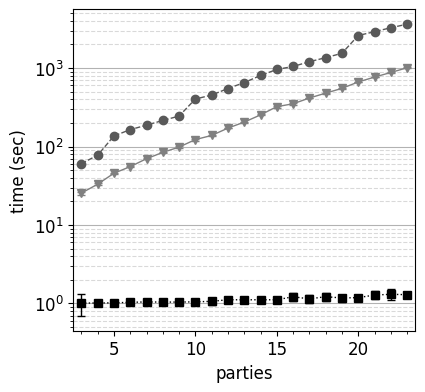

In [43]:
# Total runtime
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "total_runtime", median_column="total_runtime", style=styles[0])
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "total_runtime", median_column="total_runtime", style=styles[1])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_runtime", median_column="total_runtime", style=styles[3], semilog=True)
plt.subplots_adjust(left=0.14)
fig.savefig('figures/total_runtime.pdf')

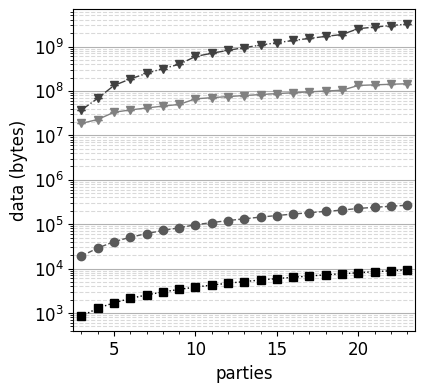

In [13]:
# Total communication cost
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "total_communication_cost", median_column="total_communication_cost", style=styles[0])
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "total_communication_cost", median_column="total_communication_cost", style=styles[1])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_communication_cost", median_column="total_communication_cost", id=1, style=styles[3])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_communication_cost", median_column="total_communication_cost", style=styles[2], semilog=True)
plt.subplots_adjust(left=0.14)
fig.savefig('figures/total_communication_cost.pdf')

Clearly active security is far more expensive than passive security
* regarding the runtime, it at least 1 and upwards of 2 orders of magnitude slower (groth < bulletproofs differ by half order of magnitude), and follows an exponential trend.
* regarding communication cost, active security using bulletproofs is a bit over 1 order of magnitude more expensive and follows a linear trend. Active security using groth16 is over 4 orders of magnitude more expensive when it is not the trusted party, and becomes increasingly more expensive when it is.

The last thing we want to look at in terms of overall performance, is the total cache storage that is required by the active security compiler

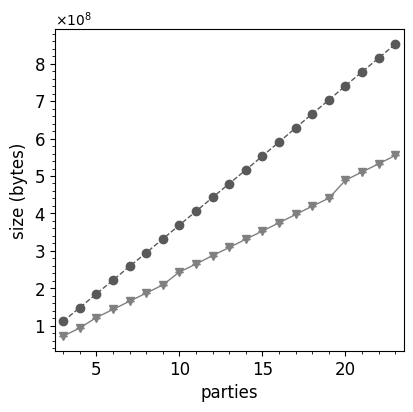

In [14]:
# Cache (memory) size
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "cache_size", median_column="cache_size", style=styles[1])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "cache_size", median_column="cache_size", style=styles[3], semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# plt.subplots_adjust(left=0.14)
fig.savefig('figures/active_cache.pdf')

### Runtime compiler phases

To understand why active security with bulletproofs requires more computation time, let's break down the runtime analysis into its parts

In [15]:
# colorful
# styles = [
#     {"label": "Bulletproofs", "marker": 'o', "linestyle": '--', "color": '#56B4E9'},
#     {"label": "Groth16", "marker": 'v', "linestyle": '-', "color": '#009E73'}
# ]

# gray scale
styles = [
    {"label": "Bulletproofs", "marker": 'o', "linestyle": '--', "color": '0.3'},
    {"label": "Groth16", "marker": 'v', "linestyle": '-', "color": '0.5'}
]

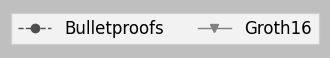

In [16]:
create_legend(styles, "figures/runtimes_legend.pdf", option='plot')

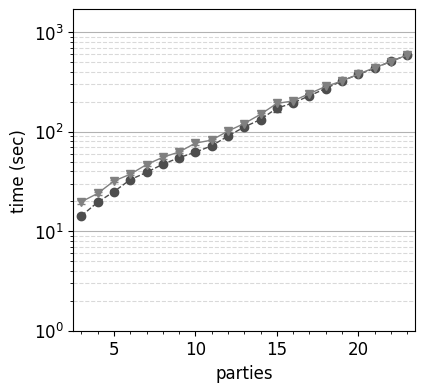

In [17]:
# Setup time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "setup_time", median_column="setup_time", std=True, style=styles[0])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "setup_time", median_column="setup_time", std=True, style=styles[1], semilog=True)
plt.ylim(1, 1700)
plt.subplots_adjust(left=0.14)
fig.savefig('figures/active_setup_time.pdf')

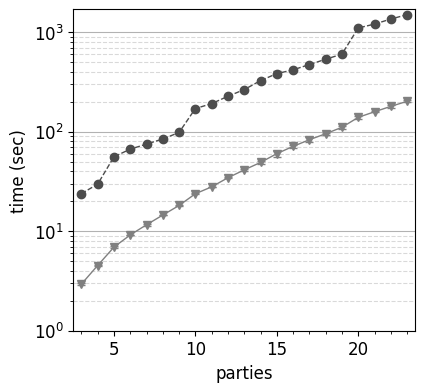

In [18]:
# Engagement time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "engagement_time", median_column="engagement_time", std=True, style=styles[0])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "engagement_time", median_column="engagement_time", std=True, style=styles[1], semilog=True)
plt.ylim(1, 1700)
plt.subplots_adjust(left=0.14)
fig.savefig('figures/active_engagement_time.pdf')

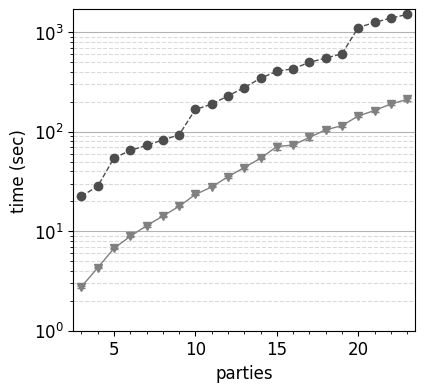

In [19]:
# Emulation time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "emulation_time", median_column="emulation_time", std=True, style=styles[0])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "emulation_time", median_column="emulation_time", std=True, style=styles[1], semilog=True)
plt.ylim(1, 1700)
plt.subplots_adjust(left=0.14)
fig.savefig('figures/active_emulation_time.pdf')

For the setup phase, it appears that both groth16 and bulletproofs are quite similar, but groth16 is a bit slower due to the trusted setup. Moreover, engagement and emulation are both similar where active security with bulletproofs is about 1 order of magnitude slower than with groth16.

#### Relative runtimes

In [20]:
def get_metric_ratio(data, metric_dict, metric='runtime', denominator="total_runtime", id=0):
    median_data, _ = get_all_measurements_alongside_median(data, denominator)
    
    # Compute a new column based on metric divided by total_runtime
    median_data_ratio = median_data[metric] / median_data[denominator]
    
    # Get data specifically for party 0
    median_data_0 = median_data_ratio[median_data['id'] == id]

    return median_data_0

Lastly we measure how all components compare against the overall runtime to see which is the bottleneck.

Runtime contributions:
* Components percentage plot: total_zkp_compile_time, total_crs_generation_time, total_proving_time, total_verification_time, remainder
* Phases percentage plot: setup_time, engagement_time, emulation_time, remainder

for cache it is kind of useless due to serialization of components, and for communication we only compare proof size to crs size (which depend on each other), so also not interesting.

##### Groth16 components

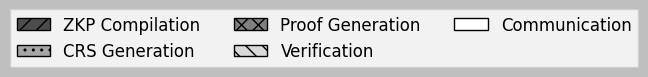

In [21]:
# colorful
# styles = [
#     {"hatch": "", "color": '#56B4E9', "label": "ZKP Compilation"},
#     {"hatch": "", "color": '#009E73', "label": "CRS Generation"},
#     {"hatch": "", "color": '#CC79A7', "label": "Proof Generation"},
#     {"hatch": "", "color": '#F0E442', "label": "Verification"},
#     {"hatch": "", "color": '1', "label": "Communication"},
# ]

# gray scale
styles = [
    {"hatch": "//", "color": '0.3', "label": "ZKP Compilation"},
    {"hatch": "..", "color": '0.65', "label": "CRS Generation"},
    {"hatch": "xx", "color": '0.5', "label": "Proof Generation"},
    {"hatch": "\\\\", "color": '0.85', "label": "Verification"},
    {"hatch": "", "color": '1', "label": "Communication"},
]

create_legend(styles, "figures/relative_component_times_legend.pdf", option='bar', ncol=3)

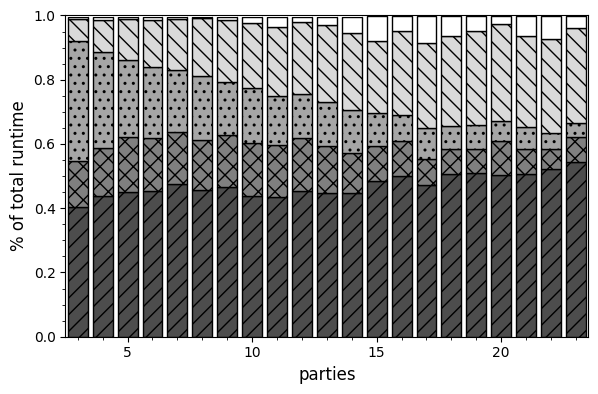

In [22]:
# For different components
zkp_compile_time_ratio = get_metric_ratio(groth16_readings, names, "total_zkp_compile_time")
crs_generation_time_ratio = get_metric_ratio(groth16_readings, names, "total_crs_generation_time")
proving_time_ratio = get_metric_ratio(groth16_readings, names, "total_proving_time")
verification_time_ratio = get_metric_ratio(groth16_readings, names, "total_verification_time")
communication_time_ratio = get_metric_ratio(groth16_readings, names, "total_communication_time")
remainder_ratio = 1 - (zkp_compile_time_ratio + crs_generation_time_ratio + proving_time_ratio + verification_time_ratio + communication_time_ratio)

components = [zkp_compile_time_ratio, crs_generation_time_ratio, proving_time_ratio, verification_time_ratio, communication_time_ratio]
order = [0,2,1,3,4]
bottoms = calculate_bottoms(order, components)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
produce_bar(bar_positions, components[0], width=bar_width, style=styles[0])
produce_bar(bar_positions, components[2], width=bar_width, style=styles[2], bottom=bottoms[0])
produce_bar(bar_positions, components[1], width=bar_width, style=styles[1], bottom=bottoms[1])
produce_bar(bar_positions, components[3], width=bar_width, style=styles[3], bottom=bottoms[2])
produce_bar(bar_positions, components[4], width=bar_width, style=styles[4], bottom=bottoms[3])
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=bottoms[4])
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
# plt.legend(loc='lower left', fontsize=12)

plt.locator_params(axis="x", integer=True, tight=True)

plt.savefig('figures/groth16_relative_component_times.pdf')

##### Bulletproofs components

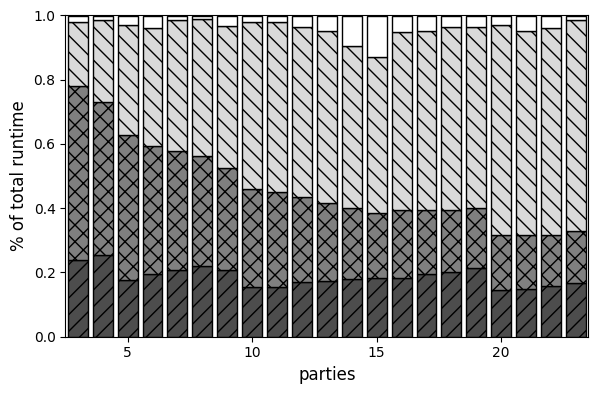

In [23]:
# For different components
zkp_compile_time_ratio = get_metric_ratio(bulletproofs_readings, names, "total_zkp_compile_time")
proving_time_ratio = get_metric_ratio(bulletproofs_readings, names, "total_proving_time")
verification_time_ratio = get_metric_ratio(bulletproofs_readings, names, "total_verification_time")
communication_time_ratio = get_metric_ratio(bulletproofs_readings, names, "total_communication_time")
remainder_ratio = 1 - (zkp_compile_time_ratio + proving_time_ratio + verification_time_ratio + communication_time_ratio)

components = [zkp_compile_time_ratio, proving_time_ratio, verification_time_ratio, communication_time_ratio]
order = [0,1,2,3]
bottoms = calculate_bottoms(order, components)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
produce_bar(bar_positions, components[0], width=bar_width, style=styles[0])
produce_bar(bar_positions, components[1], width=bar_width, style=styles[2], bottom=bottoms[0])
produce_bar(bar_positions, components[2], width=bar_width, style=styles[3], bottom=bottoms[1])
produce_bar(bar_positions, components[3], width=bar_width, style=styles[4], bottom=bottoms[2])
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='0.75', bottom=bottoms[3])


plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
# plt.legend(loc='lower left', fontsize=12)

plt.locator_params(axis="x", integer=True, tight=True)

plt.savefig('figures/bulletproofs_relative_component_times.pdf')

##### Groth16 phases

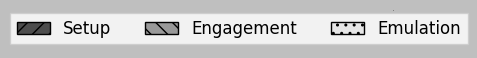

In [24]:
# colorful
# styles = [
#     {"hatch": "", "color": '#56B4E9', "label": "Setup"},
#     {"hatch": "", "color": '#CC79A7', "label": "Engagement"},
#     {"hatch": "", "color": '#F0E442', "label": "Emulation"}
# ]

# gray scale
styles = [
    {"hatch": "//", "color": '0.3', "label": "Setup"},
    {"hatch": "\\\\", "color": '0.6', "label": "Engagement"},
    {"hatch": "..", "color": '0.9', "label": "Emulation"}
]

create_legend(styles, "figures/relative_phases_times_legend.pdf", option='bar', ncol=3)

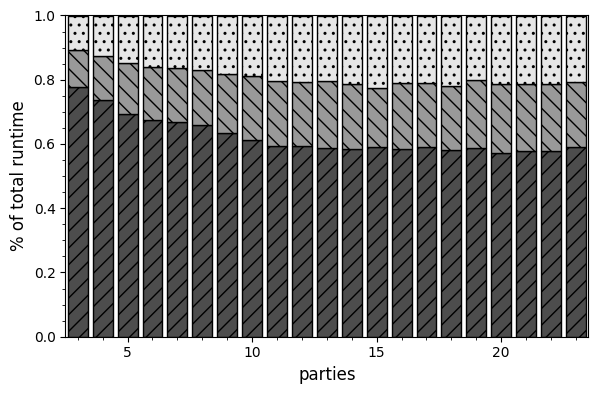

In [25]:
# For different phases
setup_time_ratio = get_metric_ratio(groth16_readings, names, "setup_time")
engagement_time_ratio = get_metric_ratio(groth16_readings, names, "engagement_time")
emulation_time_ratio = get_metric_ratio(groth16_readings, names, "emulation_time")
remainder_ratio = 1 - (setup_time_ratio + engagement_time_ratio + emulation_time_ratio)

components = [setup_time_ratio, engagement_time_ratio, emulation_time_ratio]
order = [0,1,2]
bottoms = calculate_bottoms(order, components)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
produce_bar(bar_positions, components[0], width=bar_width, style=styles[0])
produce_bar(bar_positions, components[1], width=bar_width, style=styles[1], bottom=bottoms[0])
produce_bar(bar_positions, components[2], width=bar_width, style=styles[2], bottom=bottoms[1])
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=bottoms[2])

plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
# plt.legend(loc='best', fontsize=12)

plt.locator_params(axis="x", integer=True, tight=True)

plt.savefig('figures/groth16_relative_phases_times.pdf')

##### Bulletproofs phases

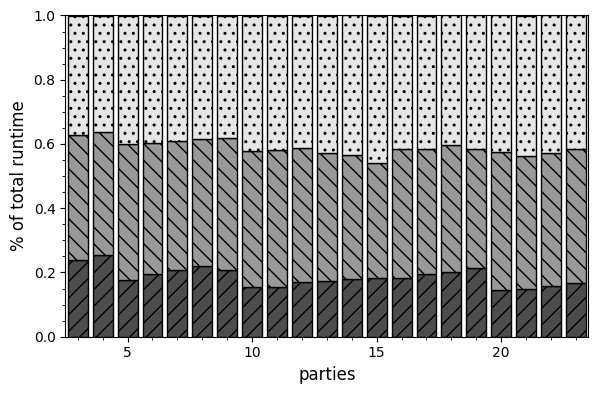

In [26]:
# For different phases
setup_time_ratio = get_metric_ratio(bulletproofs_readings, names, "setup_time")
engagement_time_ratio = get_metric_ratio(bulletproofs_readings, names, "engagement_time")
emulation_time_ratio = get_metric_ratio(bulletproofs_readings, names, "emulation_time")
remainder_ratio = 1 - (setup_time_ratio + engagement_time_ratio + emulation_time_ratio)

components = [setup_time_ratio, engagement_time_ratio, emulation_time_ratio]
order = [0,1,2]
bottoms = calculate_bottoms(order, components)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
# plt.bar(parties, setup_time_ratio, width=bar_width, hatch=patterns[0], edgecolor='black', color='0.9', bottom=engagement_time_ratio+emulation_time_ratio, label="setup")
# plt.bar(parties, engagement_time_ratio, width=bar_width, hatch=patterns[1], edgecolor='black', color='0.3', label="engagement")
# plt.bar(parties, emulation_time_ratio, width=bar_width, hatch=patterns[2], edgecolor='black', color='0.6', bottom=engagement_time_ratio, label="emulation")
# plt.bar(parties, remainder_ratio, width=bar_width, color='1', bottom=engagement_time_ratio+emulation_time_ratio+setup_time_ratio)

produce_bar(bar_positions, components[0], width=bar_width, style=styles[0])
produce_bar(bar_positions, components[1], width=bar_width, style=styles[1], bottom=bottoms[0])
produce_bar(bar_positions, components[2], width=bar_width, style=styles[2], bottom=bottoms[1])
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=bottoms[2])

plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
# plt.legend(loc='lower left', fontsize=12)

plt.locator_params(axis="x", integer=True, tight=True)

plt.savefig('figures/bulletproofs_relative_phases_times.pdf')

### Communication compiler phases

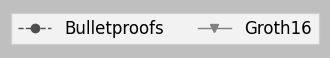

In [27]:
# colorful
# styles = [
#     {"label": "Bulletproofs", "marker": 'o', "linestyle": '--', "color": '#56B4E9'},
#     {"label": "Groth16", "marker": 'v', "linestyle": '-', "color": '#009E73'}
# ]

# gray scale
styles = [
    {"label": "Bulletproofs", "marker": 'o', "linestyle": '--', "color": '0.3'},
    {"label": "Groth16", "marker": 'v', "linestyle": '-', "color": '0.5'}
]

create_legend(styles, "figures/communication_legend.pdf", option='plot')

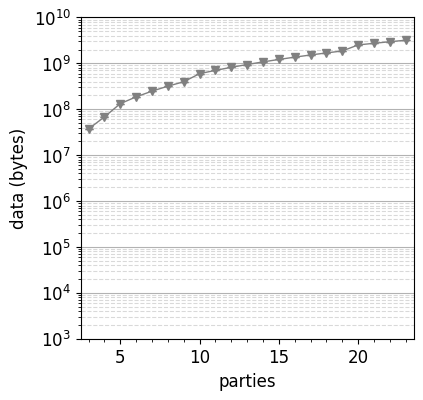

In [28]:
# Setup time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
# fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "setup_communication", median_column="setup_communication", std=False, marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "setup_communication", median_column="setup_communication", std=True, style=styles[1], semilog=True)
plt.ylim(10**3, 10**10)
plt.subplots_adjust(left=0.16)
fig.savefig('figures/active_setup_communication.pdf')

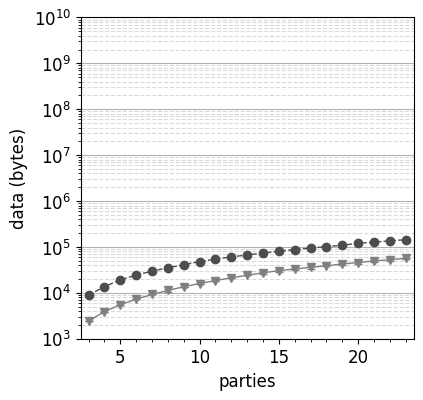

In [29]:
# Engagement time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "engagement_communication", median_column="engagement_communication", std=True, style=styles[0])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "engagement_communication", median_column="engagement_communication", std=True, style=styles[1], semilog=True)
plt.ylim(10**3, 10**10)
plt.subplots_adjust(left=0.16)
fig.savefig('figures/active_engagement_communication.pdf')

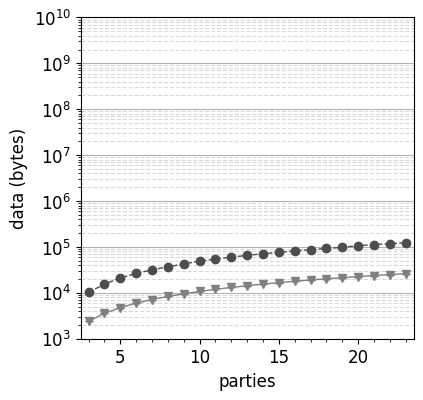

In [30]:
# Emulation time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "emulation_communication", median_column="emulation_communication", std=True, style=styles[0])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "emulation_communication", median_column="emulation_communication", std=True, style=styles[1], semilog=True)
plt.ylim(10**3, 10**10)
# plt.locator_params(axis="x", integer=True, tight=True)
plt.subplots_adjust(left=0.16)
fig.savefig('figures/active_emulation_communication.pdf')

### Relative cache size

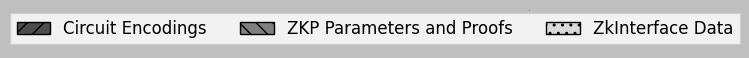

In [31]:
# colorful
# styles = [
#     {"hatch": "", "color": '#56B4E9', "label": "ZkInterface"},
#     {"hatch": "", "color": '#CC79A7', "label": "Circuit Encoding"},
#     {"hatch": "", "color": '#F0E442', "label": "ZKP Parameters and Proofs"},
# ]

# gray scale
styles = [
    {"hatch": "//", "color": '0.3', "label": "Circuit Encodings"},
    {"hatch": "\\\\", "color": '0.5', "label": "ZKP Parameters and Proofs"},
    {"hatch": "..", "color": '0.85', "label": "ZkInterface Data"},
]

create_legend(styles, "figures/relative_component_cache_legend.pdf", option='bar', ncol=3)

##### Groth16

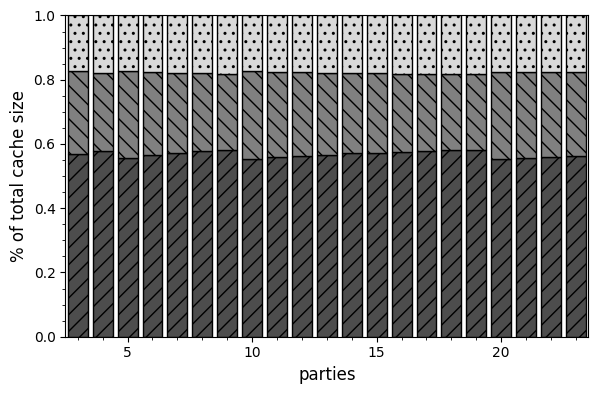

In [32]:
# For different phases
zkif_export_ratio = get_metric_ratio(groth16_readings, names, "zkif_export_size", "cache_size")
zkp_data_ratio = get_metric_ratio(groth16_readings, names, "zkp_data_size", "cache_size")
zkp_params_and_proofs_ratio = get_metric_ratio(groth16_readings, names, "zkp_params_and_proofs_size", "cache_size")
remainder_ratio = 1 - (zkif_export_ratio + zkp_data_ratio + zkp_params_and_proofs_ratio)

components = [zkp_data_ratio, zkp_params_and_proofs_ratio, zkif_export_ratio]
order = [0,1,2]
bottoms = calculate_bottoms(order, components)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
produce_bar(bar_positions, components[0], width=bar_width, style=styles[0])
produce_bar(bar_positions, components[1], width=bar_width, style=styles[1], bottom=bottoms[0])
produce_bar(bar_positions, components[2], width=bar_width, style=styles[2], bottom=bottoms[1])
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=bottoms[2])
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total cache size', fontsize=12)
# plt.legend(loc='lower left', fontsize=12)

plt.locator_params(axis="x", integer=True, tight=True)

plt.savefig('figures/groth16_relative_cache_size.pdf')

##### Bulletproofs

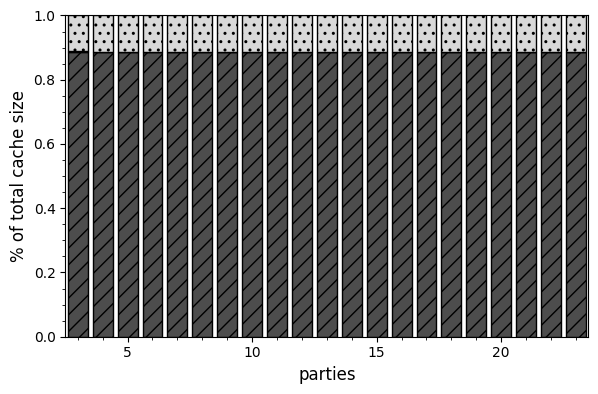

In [33]:
# For different phases
zkif_export_ratio = get_metric_ratio(bulletproofs_readings, names, "zkif_export_size", "cache_size")
zkp_data_ratio = get_metric_ratio(bulletproofs_readings, names, "zkp_data_size", "cache_size")
zkp_params_and_proofs_ratio = get_metric_ratio(bulletproofs_readings, names, "zkp_params_and_proofs_size", "cache_size")
remainder_ratio = 1 - (zkif_export_ratio + zkp_data_ratio + zkp_params_and_proofs_ratio)

components = [zkp_data_ratio, zkp_params_and_proofs_ratio, zkif_export_ratio]
order = [0,1,2]
bottoms = calculate_bottoms(order, components)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
produce_bar(bar_positions, components[0], width=bar_width, style=styles[0])
produce_bar(bar_positions, components[1], width=bar_width, style=styles[1], bottom=bottoms[0])
produce_bar(bar_positions, components[2], width=bar_width, style=styles[2], bottom=bottoms[1])
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=bottoms[2])
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total cache size', fontsize=12)
# plt.legend(loc='lower left', fontsize=12)

plt.locator_params(axis="x", integer=True, tight=True)

plt.savefig('figures/bulletproofs_relative_cache_size.pdf')

### Breakdown of setup phase

We measure the runtime and size of the components in setup phase, more specifically the ZKP compilation runtime and number of constraints, and the CRS generation runtime and size:

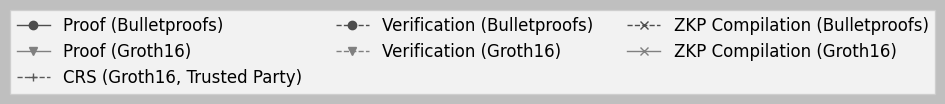

In [34]:
# colorful
# styles = [
#     {"label": "Proof (Bulletproofs)", "marker": 'o', "linestyle": '-', "color": '#56B4E9'},
#     {"label": "Proof (Groth16)", "marker": 'v', "linestyle": '-', "color": '#009E73'},
#     {"label": "CRS (Groth16, Trusted Party)", "marker": '+', "linestyle": '--', "color": '#CC79A7'},
#     {"label": "Verification (Bulletproofs)", "marker": 'o', "linestyle": '-.', "color": '#0072B2'},
#     {"label": "Verification (Groth16)", "marker": 'v', "linestyle": '-.', "color": '#E69F00'},
#     {"label": "ZKP Compilation (Bulletproofs)", "marker": 'x', "linestyle": '--', "color": 'black'},
#     {"label": "ZKP Compilation (Groth16)", "marker": 'x', "linestyle": '-', "color": 'gray'},
# ]

# gray scale
styles = [
    {"label": "Proof (Bulletproofs)", "marker": 'o', "linestyle": '-', "color": '0.3'},
    {"label": "Proof (Groth16)", "marker": 'v', "linestyle": '-', "color": '0.5'},
    {"label": "CRS (Groth16, Trusted Party)", "marker": '+', "linestyle": '--', "color": '0.35'},
    {"label": "Verification (Bulletproofs)", "marker": 'o', "linestyle": '--', "color": '0.3'},
    {"label": "Verification (Groth16)", "marker": 'v', "linestyle": '--', "color": '0.5'},
    {"label": "ZKP Compilation (Bulletproofs)", "marker": 'x', "linestyle": '--', "color": '0.3'},
    {"label": "ZKP Compilation (Groth16)", "marker": 'x', "linestyle": '-', "color": '0.5'},
]

create_legend(styles, "figures/runtime_component_measurements_legend.pdf", option='plot', ncol=3)

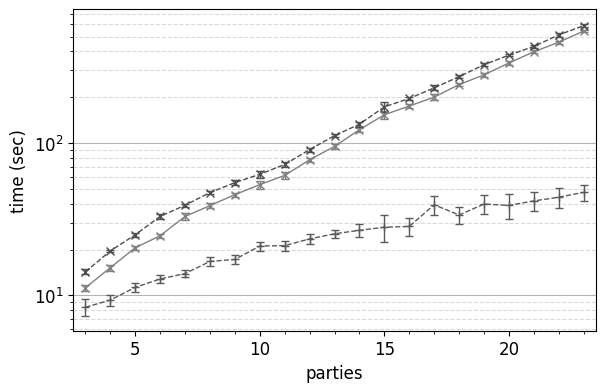

In [35]:
# Total CRS generation and ZKP compilation time
# fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, d2 = produce_plot(fig, ax, groth16_readings, names, "total_zkp_compile_time", median_column="total_zkp_compile_time", style=styles[6])
fig, ax, d1 = produce_plot(fig, ax, bulletproofs_readings, names, "total_zkp_compile_time", median_column="total_zkp_compile_time", style=styles[5])
fig, ax, d3 = produce_plot(fig, ax, groth16_readings, names, "total_crs_generation_time", median_column="total_crs_generation_time", style=styles[2], semilog=True)
plt.locator_params(axis="x", integer=True, tight=True)
# plt.subplots_adjust(left=0.14)
fig.savefig('figures/zkp_comp_crs_gen.pdf')

We see that ZKP compilation time has an exponential trend, while CRS generation time seems to follow more of a linear trend. Also, since ZKP generation for groth16 is consistantly faster than ZKP generation for bulletproofs and since the magnitude is significantly higher than CRS generation, it justifies why the setup phase runtimes are similar for bulletproofs and groth16.

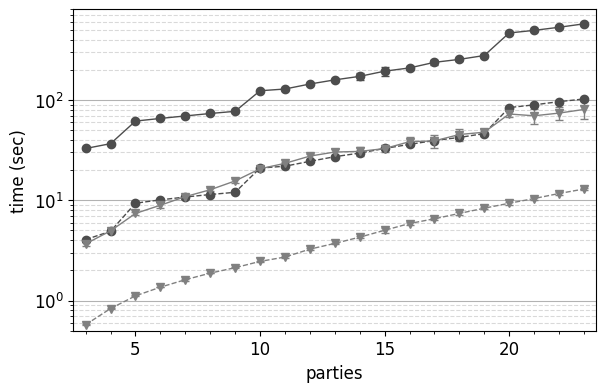

In [36]:
# Total proof generation and nominal verification time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "total_proving_time", median_column="total_proving_time", style=styles[0])
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "total_verification_time_per_party", median_column="total_verification_time_per_party", style=styles[3])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_proving_time", median_column="total_proving_time", style=styles[1])
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_verification_time_per_party", median_column="total_verification_time_per_party", style=styles[4], semilog=True)
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylim(0.5, 800)
fig.savefig('figures/active_proving_verification_time.pdf')

The proof generation time for groth16 == nominal verification time for bulletproofs, which explains the significant runtime difference between both systems as verification time additionally has a multiplicative factor that is linear in the number of parties.

### Size and constraints

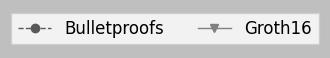

In [37]:
# colorful
# styles = [
#     {"label": "Bulletproofs", "marker": 'o', "linestyle": '--', "color": '#56B4E9'},
#     {"label": "Groth16", "marker": 'v', "linestyle": '-', "color": '#009E73'},
# ]

# gray scale
styles = [
    {"label": "Bulletproofs", "marker": 'o', "linestyle": '--', "color": '0.35'},
    {"label": "Groth16", "marker": 'v', "linestyle": '-', "color": '0.5'},
]

create_legend(styles, "figures/sizes_measurements_legend.pdf", option='plot', ncol=3)

Next, we want to understand where this difference in ZKP compilation may come from. Let's look at the number of constraints for groth16 and bulletproofs and their difference

In [38]:
_, _, constraints_groth16 = produce_plot(fig, ax, groth16_readings, names, "total_zkp_constraints", style={"label":""})
_, _, constraints_bulletproofs = produce_plot(fig, ax, bulletproofs_readings, names, "total_zkp_constraints", style={"label":""})
zk_constraints = pd.DataFrame(zip(list(constraints_groth16), list(constraints_bulletproofs)), columns=['groth16', 'bulletproofs'])
zk_constraints["difference"] = zk_constraints["groth16"] - zk_constraints["bulletproofs"]

# Set 'parties' as the index and name the index column as 'parties'
zk_constraints.set_index(pd.Index(parties), inplace=True)
zk_constraints.index.name = 'parties'
zk_constraints = zk_constraints.astype(int)

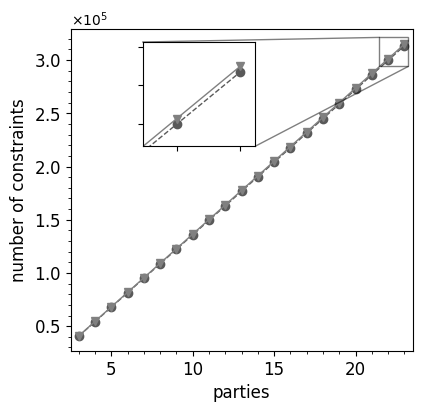

In [39]:
# Total ZKP constraints
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
# fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')

ax.plot(parties, zk_constraints["bulletproofs"], linewidth=1, markersize=6, color=styles[0]['color'], marker=styles[0]['marker'], linestyle=styles[0]['linestyle'])
ax.plot(parties, zk_constraints["groth16"], linewidth=1, markersize=6, color=styles[1]['color'], marker=styles[1]['marker'], linestyle=styles[1]['linestyle'])

ax.minorticks_on()
ax.xaxis.set_major_locator(AutoLocator())
ax.set_xlim(3-0.5, max(parties)+0.5)
ax.set_xlabel('parties', fontsize=12)
ax.set_ylabel("number of constraints", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Define the zoomed-in region
x1, x2 = max(parties)*(2.8/3), max(parties)*(3/3 + 0.01)
y1, y2 = max(zk_constraints["groth16"])*(2.8/3) , max(zk_constraints["groth16"])*(3/3 + 0.02)

# Inset Axes
ax_inset = fig.add_axes([0.3, 0.6, 0.25, 0.25])  # Adjust these values as needed
ax_inset.plot(parties, zk_constraints["bulletproofs"], linewidth=1, markersize=6, color=styles[0]['color'], marker=styles[0]['marker'], linestyle=styles[0]['linestyle'])
ax_inset.plot(parties, zk_constraints["groth16"], linewidth=1, markersize=6, color=styles[1]['color'], marker=styles[1]['marker'], linestyle=styles[1]['linestyle'])
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])
ax.indicate_inset_zoom(ax_inset, edgecolor="black")
plt.subplots_adjust(left=0.14)
fig.savefig('figures/zkp_constraints.pdf')

While it is not surprising that bulletproofs require fewer constraints (smaller prime field modulus), it is surprising that the ZKP compilation time is slower. Understanding why is beyond the scope, could be because of ECC operations, or optimization of specific R1CS

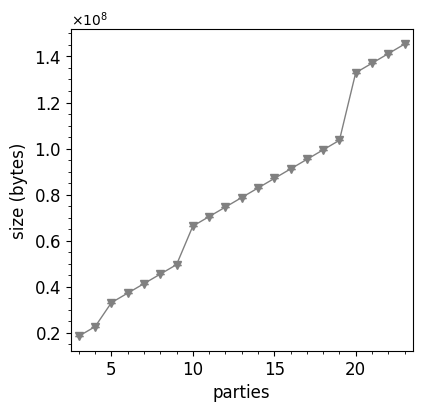

In [40]:
# Total CRS length
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_crs_len", style=styles[1], semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.subplots_adjust(left=0.14)
fig.savefig('figures/crs_length.pdf')

ZKP constraints are clearly linear with party size, while CRS length is linear but has steep increments at m=5, m=9 and m=20

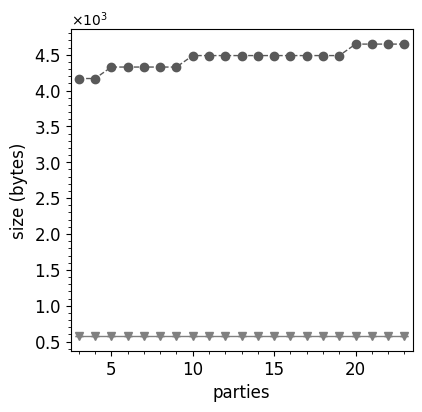

In [41]:
# Total CRS length and ZKP constraints
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "total_proof_size", style=styles[1])
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "total_proof_size", style=styles[0], semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.subplots_adjust(left=0.14)
fig.savefig('figures/active_proof_size.pdf')

Groth16 always produces constant size proofs, whereas Bulletproofs are sublinear in the size of number of constraints, and can be explained by number of generators required being a power of 2 w.r.t number of constraints/multiplications